In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from utils.data_utils import *

In [116]:
# 更改 utils/data_utils.py 中的自訂 function 可重新 reload
from importlib import reload
from utils import data_utils
reload(data_utils)
from utils.data_utils import *

# Read data

In [3]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
load = pd.read_pickle(path + 'load_nyisocom.pickle')
print(f'原始資料數量: {load.shape}')

原始資料數量: (2174180, 3)


In [4]:
# 2005-01-31 之前, NYC 和 LONG IL 是並在一起, 資料不適合使用
# load = load[(load['Date']>='2005-01-31 00:00:00')]
load = load[(load['Date']>='2005-01-31 00:00:00') & (load['Date']<='2016-12-31 23:00:00')]
print(f'選定區間後原始資料數量: {load.shape}')

選定區間後原始資料數量: (1149191, 3)


# Clean data

## 原先資料就有的NA 
(後面NA一起處理)

In [5]:
print(load['Load'].isna().sum())
# load[load['Load'].isna()]

33


## unusal values

### Explore

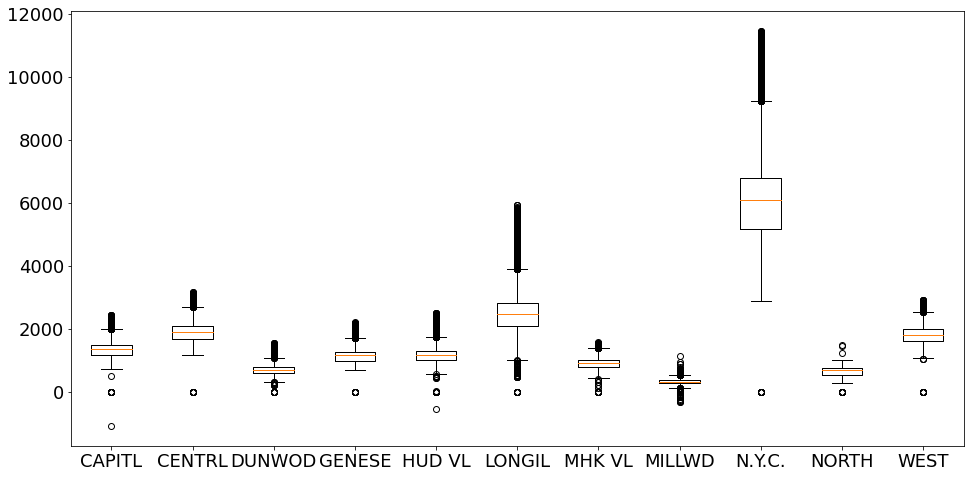

In [6]:
df = load

load_data_by_zone = []
# 遍歷每個類別，將相應的Load數據添加到列表中
for zone, data in df.groupby('Zone')['Load']:
    load_data_by_zone.append(data)

# 繪製箱形圖
plt.figure(figsize=(16, 8))
plt.boxplot(load_data_by_zone, labels=df['Zone'].unique(), vert=True)
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.show()

### Remove 0 and negative

In [7]:
print(f'刪除前資料數量: {df.shape}')
non_pos = df[df['Load']<=0]
print(f'小於等於0的數量: {non_pos.shape}')
load_drop = df.drop(non_pos.index) 
print(f'刪除後資料數量: {load_drop.shape}')

刪除前資料數量: (1149191, 3)
小於等於0的數量: (115, 3)
刪除後資料數量: (1149076, 3)


In [8]:
zones = load['Zone'].unique()
for zone in zones:
    non_pos = df[(df['Load']<=0) & (df['Zone']==zone)]
    print(f'{zone} 小於等於0的數量: {non_pos.shape}')

CAPITL 小於等於0的數量: (10, 3)
CENTRL 小於等於0的數量: (9, 3)
DUNWOD 小於等於0的數量: (9, 3)
GENESE 小於等於0的數量: (9, 3)
HUD VL 小於等於0的數量: (10, 3)
LONGIL 小於等於0的數量: (9, 3)
MHK VL 小於等於0的數量: (9, 3)
MILLWD 小於等於0的數量: (23, 3)
N.Y.C. 小於等於0的數量: (9, 3)
NORTH 小於等於0的數量: (9, 3)
WEST 小於等於0的數量: (9, 3)


## duplicate


### Explore

In [9]:
df = load_drop

# 確認有多少重複值
duplicates = df[df.duplicated(subset=['Date', 'Zone'], keep = False)]
print(f'重複筆數：{duplicates.shape}')

print(duplicates.head(1))
df[(df['Date'] == '2014-11-02 01:00:00')&(df['Zone']=='N.Y.C.')]

重複筆數：(196, 3)
                      Date    Zone    Load
490147 2005-03-26 01:00:00  CENTRL  1692.1


,Date,Zone,Load
1812720,2014-11-02 01:00:00,N.Y.C.,4400.5
1812721,2014-11-02 01:00:00,N.Y.C.,4221.8


In [10]:
zones = load['Zone'].unique()
for zone in zones:
    df_zone = df[(df['Zone']==zone)]
    duplicates = df_zone[df_zone.duplicated(subset=['Date', 'Zone'])]
    print(f'{zone} 重複筆數: {duplicates.shape}')

CAPITL 重複筆數: (8, 3)
CENTRL 重複筆數: (9, 3)
DUNWOD 重複筆數: (9, 3)
GENESE 重複筆數: (9, 3)
HUD VL 重複筆數: (9, 3)
LONGIL 重複筆數: (9, 3)
MHK VL 重複筆數: (9, 3)
MILLWD 重複筆數: (9, 3)
N.Y.C. 重複筆數: (9, 3)
NORTH 重複筆數: (9, 3)
WEST 重複筆數: (9, 3)


In [11]:
df = load_drop

# 確認有多少重複值
duplicates_first = df[df.duplicated(subset=['Date', 'Zone'], keep = "first")]
duplicates_last = df[df.duplicated(subset=['Date', 'Zone'], keep = "last")]

In [12]:
new_df = pd.merge(duplicates_first, duplicates_last,  how='left', left_on=['Date','Zone'], right_on = ['Date','Zone'])
new_df

,Date,Zone,Load_x,Load_y
0,2005-03-26 01:00:00,CENTRL,1693.6,1692.1
1,2005-03-26 01:00:00,DUNWOD,544.7,543.9
2,2005-03-26 01:00:00,GENESE,888.1,887.1
3,2005-03-26 01:00:00,HUD VL,938.1,937.3
4,2005-03-26 01:00:00,LONGIL,1872.8,1870.3
...,...,...,...,...
93,2010-11-07 01:00:00,MHK VL,594.1,607.1
94,2010-11-07 01:00:00,MILLWD,237.8,230.3
95,2010-11-07 01:00:00,N.Y.C.,4327.7,4502.5
96,2010-11-07 01:00:00,NORTH,468.0,470.1


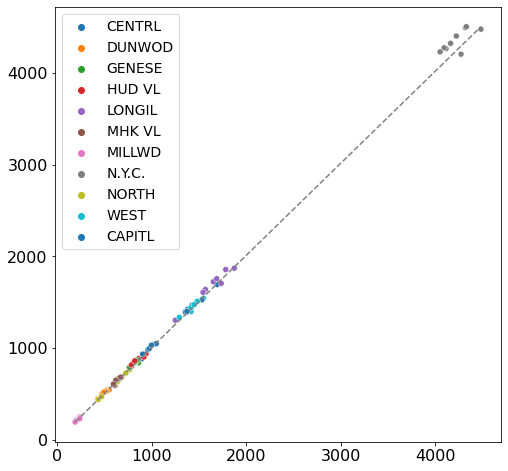

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for categorical colormap

plt.figure(figsize=(8, 8)) 
# Assuming new_df is your DataFrame
scatterplot = sns.scatterplot(x='Load_x', y='Load_y', hue='Zone', data=new_df, palette='tab10')

# Adding labels and title
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('', fontsize=20)

# Set tick label font sizes
plt.tick_params(axis='both', labelsize=16)

# Adjust legend text size
scatterplot.legend(fontsize=14)

# Add a 45-degree line
plt.plot([min(new_df['Load_x']), max(new_df['Load_x'])], [min(new_df['Load_y']), max(new_df['Load_y'])], linestyle='--', color='gray')

# Display the plot
plt.show()


### Take an average of duplicates

In [14]:
# about 1m 10s
df= load_drop

# 重複中有兩筆資料的取平均
print(f'刪除前資料數量: {df.shape}')
duplicates = df[df.duplicated(subset=['Date', 'Zone'])]

print(f'重複筆數: {duplicates.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'刪除後資料數量: {df_drop.shape}')

load_drop = df_drop

刪除前資料數量: (1149076, 3)
重複筆數: (98, 3)
刪除後資料數量: (1148978, 3)


## NA 

In [15]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')
print(f'沒紀錄數量(包含原本是<=0被drop掉的): {df_all_time.shape[0]-df.shape[0]}')
min_date = df['Date'].min(); max_date = df['Date'].max()
print(f'min: {min_date}')
print(f'max: {max_date}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 - 所有時間點 x 11 zones:{hours_df.shape[0]*11}')



df_all_time = df_all_time

目前資料數量: (1148978, 3)
補上所有時間後資料數量: (1149192, 3)
沒紀錄數量(包含原本是<=0被drop掉的): 214
min: 2005-01-31 00:00:00
max: 2016-12-31 23:00:00
驗算 - 所有時間點 x 11 zones:1149192


In [16]:
for zone in zones:
    num = df_all_time[df_all_time['Zone']==zone].shape[0] - df[df['Zone']==zone].shape[0]
    print(f'{zone} 沒紀錄數量(包含原本是<=0被drop掉的): {num}')

CAPITL 沒紀錄數量(包含原本是<=0被drop掉的): 19
CENTRL 沒紀錄數量(包含原本是<=0被drop掉的): 18
DUNWOD 沒紀錄數量(包含原本是<=0被drop掉的): 18
GENESE 沒紀錄數量(包含原本是<=0被drop掉的): 18
HUD VL 沒紀錄數量(包含原本是<=0被drop掉的): 19
LONGIL 沒紀錄數量(包含原本是<=0被drop掉的): 18
MHK VL 沒紀錄數量(包含原本是<=0被drop掉的): 18
MILLWD 沒紀錄數量(包含原本是<=0被drop掉的): 32
N.Y.C. 沒紀錄數量(包含原本是<=0被drop掉的): 18
NORTH 沒紀錄數量(包含原本是<=0被drop掉的): 18
WEST 沒紀錄數量(包含原本是<=0被drop掉的): 18


In [17]:
for zone in zones:
    df_onezone = df_all_time.loc[df_all_time['Zone'] == zone,]
    print(f"{zone} total NA number (包含原本存在的3個NA): {df_onezone['Load'].isna().sum()}") 

CAPITL total NA number (包含原本存在的3個NA): 22
CENTRL total NA number (包含原本存在的3個NA): 21
DUNWOD total NA number (包含原本存在的3個NA): 21
GENESE total NA number (包含原本存在的3個NA): 21
HUD VL total NA number (包含原本存在的3個NA): 22
LONGIL total NA number (包含原本存在的3個NA): 21
MHK VL total NA number (包含原本存在的3個NA): 21
MILLWD total NA number (包含原本存在的3個NA): 35
N.Y.C. total NA number (包含原本存在的3個NA): 21
NORTH total NA number (包含原本存在的3個NA): 21
WEST total NA number (包含原本存在的3個NA): 21


# Export data: 產出要使用的資料 (pd to np array)

要產生可以餵進 SSSD code 的資料格式 np array (observation, channel, length)

## Dataset 4: 8 days + remove na + z normalization

移除 NA 在 'train_test_select' 內執行

### Each zone

In [95]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
# zones = df_all_time_ls[0]['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])
    # save
    np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

In [151]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）

for index in range(len(zones)):
    load_array_train, load_array_test, day_of_week_train, day_of_week_test = train_test_select_2(df_all_time, 
        train_start = '2005-01-31 00:00:00',
        train_end = '2016-10-19 23:00:00', 
        test_start = '2016-10-13 00:00:00',
        test_end = '2016-12-31 23:00:00',
        zone_number = 1,
        days_window = days_window,
        zone_name = zones[index])
    # normalization
    # load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    # load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    # np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    # np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    # np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)  

    np.save(path + '/zone/'+zones[index]+'_day_of_week_train.npy', day_of_week_train)
    np.save(path + '/zone/'+zones[index]+'_day_of_week_test.npy', day_of_week_test)                                            

### All

In [96]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(47003, 192, 1)
(803, 192, 1)


### Mix

In [97]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

load_array_mix_train = np.concatenate([np.load(path + '/zone/'+zone+'_train.npy') for zone in zones]) 
load_array_mix_test = np.concatenate([np.load(path + '/zone/'+zone+'_test.npy') for zone in zones]) 
load_array_mix_train_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_train_stdd.npy') for zone in zones]) 
load_array_mix_test_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_test_stdd.npy') for zone in zones]) 

np.save(path + 'mix/load_array_mix_train.npy', load_array_mix_train)
np.save(path + 'mix/load_array_mix_test.npy', load_array_mix_test)
np.save(path + 'mix/load_array_mix_train_stdd.npy', load_array_mix_train_stdd)
np.save(path + 'mix/load_array_mix_test_stdd.npy', load_array_mix_test_stdd)

### zone split

In [34]:
path = "/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/"

# creat 'zone_split' folder
if not os.path.exists(path+'zone_split'):
    os.makedirs(path+'zone_split')

# create list containing file names of training data
file_ls = os.listdir(path+'zone')
train_files_ls = [file for file in file_ls if 'train' in file]

for file in train_files_ls:
    # read
    data_npy = np.load(path+'zone/'+file)

    # 將資料分成 I1 和 I2
    np.random.seed(42)

    random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
    remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

    sample_I1 = data_npy[random_indices]
    sample_I2 = data_npy[remaining_indices]

    # save
    np.save(path+'zone_split/I1_'+file, sample_I1)
    np.save(path+'zone_split/I2_'+file, sample_I2)


## Dataset 5:  8 days + remove na + range normalization

移除 NA 在 'train_test_select' 內執行

### Each zone

In [106]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
# zones = df_all_time_ls[0]['Zone'].unique()

for index in range(len(zones)):   
    load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = range_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = range_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

### All

In [104]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = range_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = range_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(47003, 192, 1)
(803, 192, 1)


### Mix

In [107]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
# zones = all_impute_stl_ls[0]['Zone'].unique()

load_array_mix_train = np.concatenate([np.load(path + '/zone/'+zone+'_train.npy') for zone in zones]) 
load_array_mix_test = np.concatenate([np.load(path + '/zone/'+zone+'_test.npy') for zone in zones]) 
load_array_mix_train_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_train_stdd.npy') for zone in zones]) 
load_array_mix_test_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_test_stdd.npy') for zone in zones]) 

np.save(path + 'mix/load_array_mix_train.npy', load_array_mix_train)
np.save(path + 'mix/load_array_mix_test.npy', load_array_mix_test)
np.save(path + 'mix/load_array_mix_train_stdd.npy', load_array_mix_train_stdd)
np.save(path + 'mix/load_array_mix_test_stdd.npy', load_array_mix_test_stdd)

### zone split

In [5]:
path = "/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/"

# creat 'zone_split' folder
if not os.path.exists(path+'zone_split'):
    os.makedirs(path+'zone_split')

# create list containing file names of training data
file_ls = os.listdir(path+'zone')
train_files_ls = [file for file in file_ls if 'train' in file]

for file in train_files_ls:
    # read
    data_npy = np.load(path+'zone/'+file)

    # 將資料分成 I1 和 I2
    np.random.seed(42)

    random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
    remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

    sample_I1 = data_npy[random_indices]
    sample_I2 = data_npy[remaining_indices]

    # save
    np.save(path+'zone_split/I1_'+file, sample_I1)
    np.save(path+'zone_split/I2_'+file, sample_I2)


# Day of the week

In [147]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
# zones = df_all_time_ls[0]['Zone'].unique()

index = 9
load_array_train, load_array_test, day_of_week_train, day_of_week_test = train_test_select(df_all_time, 
                                     train_start = '2005-01-31 00:00:00',
                                     train_end = '2016-10-19 23:00:00', 
                                     test_start = '2016-10-13 00:00:00',
                                     test_end = '2016-12-31 23:00:00',
                                     zone_number = 1,
                                     days_window = days_window,
                                     zone_name = zones[index])


In [139]:
zones[index]

'NORTH'

In [138]:
print(load_array_train.shape)
print(day_of_week_train.shape)

(4115, 192, 1)
(4115,)


In [148]:
dd = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/zone/NORTH_train.npy')

In [149]:
dd[0,0:3,0]

array([816.2, 820.3, 815.5])

In [150]:
load_array_train[0,0:3,0]

array([816.2, 820.3, 815.5])

In [51]:
import datetime
from datetime import timedelta

datetime.date(2005,2,7).weekday()

0